In [9]:
# Jupyter notebook needs this or else it will crash
from datetime import datetime
import nest_asyncio
nest_asyncio.apply()

from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.traversal import P # NEW!!! Import predicates (gt, gte, lt, lte, etc.)
from gremlin_python.process.traversal import Cardinality # NEW!!! Import Cardinality such as list_, set_ and single.
from gremlin_python.driver.protocol import GremlinServerError # Gremlin server error
from gremlin_python.process.traversal import Pop # for Pop.all_ in select(Pop.all_, 'v')

# Instantiate a Gremlin Graph
graph = Graph()

# Connect to the server, instantiate traversal of graph.
g = graph.traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin','g'))

In [10]:
def connected(name1: str, name2: str, time: float) -> bool:
    """
    Given two vertices labelled with <name1> and <name2>, determine whether they were connected at time <time>. 
    Do so by sending a Gremlin query to determine whether there exists an edge between the 
    two vertices such that <time> falls in between their "start_time" and "end_time" parameters.
    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    # Get the vertices associated with the names
    # v1, v2 = g.V().has('name', name1).next(), g.V().has('name', name2).next()

    # Return whether there are edges that:
    #   - connect v1 and v2, 
    #   - labelled 'connection',
    #   - have a start time that is less than or equal to <time>
    #   - either do not have an end time or have an end time that is greater than or equal to <time>
    return g.V().has('name', name1).bothE('connection').as_('e').bothV().has('name', name2).select('e').and_(
            __.has('start', P.lte(time)),   # want start time to be less than or equal to <time>
            __.or_(
                __.hasNot('end'),           # end time doesn't have to exist 
                __.has('end', P.gt(time))  # OR end time must be greater than <time>
            )
        ).count().next() > 0

In [11]:
def set_connection(name1: str, name2: str, time: float, connection: bool) -> None:
    """
    Given two vertices labelled with <name1> and <name2>, create a new connection or terminate their existing connection, based on the value of <bool>. Label with time <time>.

    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    success = False

    while not success:

        try:

            if connection:
                # Add an edge labelled 'connection' with a start time of <time>
                g.V().has('name', name1).as_("a").not_( # NEGATE 
                    __.bothE('connection').as_('e').bothV().has('name', name2).select('e').and_(
                        __.has('start', P.lte(time)),
                        __.or_(
                            __.hasNot('end'),
                            __.has('end', P.gt(time))
                        )
                    )
                ).V().has('name', name2).as_("b").addE('connection').from_("a").to("b").property('start', time).iterate()

            else:
                # For all edges between v1 and v2 labelled 'connection' (there should only be one) that do not have an 'end' property, create an end property of <time>.
                g.V().has('name', name1).bothE('connection').as_('e').bothV().has('name', name2).select('e').hasNot('end').property('end', time).iterate()
        
            success = True

        except GremlinServerError as e:
            print(f"{datetime.now().strftime('%H:%M:%S')} ERROR: Failed to set {connection} connection between {name1} and {name2} at {time}", e)

In [12]:
def add_component(name: str) -> None:
    """
    Add a vertex to the graph with a 'name' property of <name>.

    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    success = False

    while not success:
        try:
            g.addV().property('name', name).iterate()
            success = True
        except GremlinServerError as e:
            print(f"{datetime.now().strftime('%H:%M:%S')} ERROR: Failed to add component of name {name}", e)


In [13]:
def add_type(type: str) -> None:
    """
    Add a vertex to the graph with a 'type' property of <type>.

    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    success = False

    while not success:
        try:
            g.addV().property('name', type).iterate()
            success = True
        except GremlinServerError as e:
            print(f"{datetime.now().strftime('%H:%M:%S')} ERROR: Failed to add type vertex of name {type}", e)


def set_type(name: str, type: str) -> None:
    """
    Connect the vertex labelled with <name> to a vertex labelled <type> with an edge going into the <type> vertex labelled with "type".

    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    success = False

    while not success:
        try:
            g.V().has('name', name).as_("a").V().has('name', type).as_("b").addE("type").from_("a").to("b").iterate()
            success = True
        except GremlinServerError as e:
            print(f"{datetime.now().strftime('%H:%M:%S')} ERROR: Failed to set type of {name} to {type}", e)

In [14]:
# This will put it in V-E-V-E-V-...-V form as a list per path.
def find_paths(name1: str, name2: str, avoid_type: str, time: float):
    """
    Given two vertices labelled with <name1> and <name2>, return the paths that connect the vertices by edges that were active at <time> as a list.

    Avoid vertices of type avoid_type.

    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """
    while True:
        try:
            return g.V().has('name', name1).repeat(
            __.bothE('connection').and_(
                __.has('start', P.lte(time)),   # want start time to be less than or equal to <time>
                __.or_(
                    __.hasNot('end'),           # end time doesn't have to exist 
                    __.has('end', P.gt(time))  # OR end time must be greater than <time>
                )
            ).otherV().not_(__.outE('type').inV().has('name', avoid_type)).simplePath()
        ).until(__.has('name', name2)).path().toList()
        except GremlinServerError as e:
            print(f"{datetime.now().strftime('%H:%M:%S')} ERROR: Could not find paths between {name1} and {name2} at time {time} avoiding {avoid_type}.", e)
    

In [15]:
# number of HIRAX dishes
dishes = 1024

# Connections at every 3.
max_time = 30
connections = [(i, not bool(i % 2)) for i in range(0, max_time // 3 + 1, 3)]

# Correlator node name 
cor = 'COR000000'

In [16]:
# Clear vertices
# Doing this does NOT use indexing.
g.V().drop().iterate()
g.E().drop().iterate()

"""
(Temporary) Naming scheme:
 - COR######: Correlator input
 - ANT######: Antenna
 - DPF######: Dual-Polarization Feed
 - BLN######: (Active) Balun
 - RFT######: RFoF transmitter
 - OPF######: Optical Fiber
 - RFR######: RFoF receiver
 - ADC######: Analog-to-Digital converter
"""

# Set up the types
types = ['COR', 'ANT', 'DPF', 'BLN', 'RFT', 'OPF', 'RFR', 'ADC']
for type in types:
    add_type(type)


# Add a correlator input node
add_component(cor)
set_type(cor, 'COR')

# Add the components and connect them at different times.
for i in range(1, dishes + 1):



    # The names of the components to refer to
    ant = f'ANT{str(i).zfill(6)}'
    dpf = f'DPF{str(i).zfill(6)}'
    bln = (f'BLN{str(2 * i - 1).zfill(6)}', f'BLN{str(2 * i).zfill(6)}')
    rft = (f'RFT{str(2 * i - 1).zfill(6)}', f'RFT{str(2 * i).zfill(6)}')
    opf = (f'OPF{str(2 * i - 1).zfill(6)}', f'OPF{str(2 * i).zfill(6)}')
    rfr = (f'RFR{str(2 * i - 1).zfill(6)}', f'RFR{str(2 * i).zfill(6)}')
    adc = (f'ADC{str(2 * i - 1).zfill(6)}', f'ADC{str(2 * i).zfill(6)}')

    now = datetime.now()

    add_component(ant)
    add_component(dpf)

    set_type(ant, 'ANT')
    set_type(dpf, 'DPF')

    for ind in (0, 1):
        add_component(bln[ind])
        add_component(rft[ind])
        add_component(opf[ind])
        add_component(rfr[ind])
        add_component(adc[ind])

        set_type(bln[ind], 'BLN')
        set_type(rft[ind], 'RFT')
        set_type(opf[ind], 'OPF')
        set_type(rfr[ind], 'RFR')
        set_type(adc[ind], 'ADC')

    for (time, connection) in connections:

        set_connection(name1=ant, name2=dpf, time=time, connection=connection)

        for ind in (0, 1):

            # Pairs of names to connect
            pairs = [(ant, dpf), (dpf, bln[ind]), (bln[ind], rft[ind]), (rft[ind], opf[ind]), (opf[ind], rfr[ind]), (rfr[ind], adc[ind]), (adc[ind], cor)]

            for pair in pairs:
                set_connection(name1=pair[0], name2=pair[1], time=time, connection=connection)

    print(f"Dish {i} done, took {(datetime.now() - now).total_seconds()}")



# EXPORT THE GRAPH.
# g.io("path_benchmark_small_graph.xml").write().next()




364217
Dish 334 done, took 0.362874
Dish 335 done, took 0.347528
Dish 336 done, took 0.388944
Dish 337 done, took 0.358132
Dish 338 done, took 0.36711
Dish 339 done, took 0.350881
Dish 340 done, took 0.35716
Dish 341 done, took 0.354166
Dish 342 done, took 0.357704
Dish 343 done, took 0.361475
Dish 344 done, took 0.352933
Dish 345 done, took 0.354094
Dish 346 done, took 0.365411
Dish 347 done, took 0.358112
Dish 348 done, took 0.35626
Dish 349 done, took 0.345665
Dish 350 done, took 0.362853
Dish 351 done, took 0.357752
Dish 352 done, took 0.343834
Dish 353 done, took 0.355934
Dish 354 done, took 0.347696
Dish 355 done, took 0.36713
Dish 356 done, took 0.340329
Dish 357 done, took 0.348556
Dish 358 done, took 0.351212
Dish 359 done, took 0.356301
Dish 360 done, took 0.356154
Dish 361 done, took 0.345601
Dish 362 done, took 0.36082
Dish 363 done, took 0.359854
Dish 364 done, took 0.355207
Dish 365 done, took 0.350667
Dish 366 done, took 0.346761
Dish 367 done, took 0.338315
Dish 368 don

ection->214864072], v[214864072], e[{'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '3hsjrt-3jxa6g-36d-2v2io'}}][214864072-connection->4808832], v[4808832], e[{'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '1um1c-2v2io-36d-3dxr20'}}][4808832-connection->204808248], v[204808248]], path[v[4862032], e[{'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '1v3ey-2w7kg-36d-2uzcw'}}][4862032-connection->4804736], v[4804736], e[{'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '1umfk-2uzcw-36d-3jxdc8'}}][4804736-connection->214868168], v[214868168], e[{'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '3hsk61-3jxdc8-36d-2wdw0'}}][214868168-connection->4870224], v[4870224], e[{'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '1v47e-2wdw0-36d-2wh1s'}}][4870224-connection->4874320], v[4874320], e[{'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '1v4lm-2wh1s-36d-31qoo'}}]

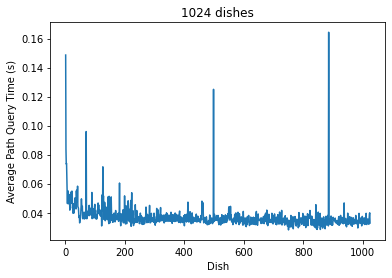

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# To benchmark, try finding all of the paths from the correlator to each of the antennas, and time it.
iterations = 1

times_to_query = [2]

total = 0

print(f"Dishes: {dishes}")
print(f"Times to check: {times_to_query}")
print(f"Iterations: {iterations}")

dish_times = []

for _ in range(iterations):
    for i in range(len(times_to_query)):
        time = times_to_query[i]
        for dish in range(1, dishes + 1):

            success = False
            while not success:
                try:
                    then = datetime.now()
                    paths = find_paths(name1=f'ANT{str(dish).zfill(6)}', name2=cor, time=time, avoid_type='')
                    #find_paths(name1=cor, name2=f'ANT{str(dish).zfill(6)}', time=time, avoid_type='')

                    delta = (datetime.now() - then).total_seconds()

                    total += delta

                    print(f"Dish {dish} done, time:", delta, paths)

                    dish_times.append(delta)

                    success = True
                except GremlinServerError:
                    print("Uh oh! Backend exception!")

        print(f"{len(times_to_query) - i - 1} times left to check!")

print("Total time:", total)
print("Average time per call:", total / (iterations * len(times_to_query) * dishes))

plt.plot(list(range(1, dishes + 1)), dish_times)
plt.title(f"{dishes} dishes")
plt.xlabel("Dish")
plt.ylabel("Average Path Query Time (s)")
plt.show()
        